# LangGraph를 활용한 user - Vtuber 답변 시스템

user_input에 대한 Vtuber 답변 시스템 입니다. 
user_input은 추후 치지직 api 호출을 통해 큐에 담아오고, 해당 input을 차례대로 아래 GraphState에서 사용합니다.

In [10]:
from typing import TypedDict, Annotated, List
from langchain_core.documents import Document
import operator


# State 정의
class GraphState(TypedDict):
    context: Annotated[List[Document], operator.add] 
    answer: Annotated[List[Document], operator.add]
    user_input: Annotated[str, "user input"]
    prompt: Annotated[list, "final prompt"]

### 노드 정의

In [15]:
def retrieve(state: GraphState) -> GraphState:
    # retrieve: 검색
    documents = "검색된 문서"
    return GraphState(context=documents)


def llm_answer(state: GraphState) -> GraphState:
    # LLM 실행
    answer = "GPT 생성된 답변"
    return GraphState(answer=answer)

    
def prompt_handler(state: GraphState) -> GraphState:
    # 프롬프트 조립

    # persona 파라미터들 : 나중에 다른 state에서 받아오는걸로 수정
    # persona 정보
    persona_content = {"name": persona_name, "searched_sentense": page_contents}
    chat_content = {"name": persona_name, "instruction": instruction, "user_input": user_inputs}
    previous_content = {"summary": summary, "conversation_record" : custom_chat_history}

    # persona template에 정보 입력
    formatted_persona = persona.format(**persona_content)
    formatted_chat = chat.format(**chat_content)
    previous_chat = previous_chat.format(**previous_content)

    # prompt 구성
    combined_system_content = formatted_persona + "\n\n" + previous_chat
    formatted_chat = chat.format(**chat_content)
    
    prompt = [
        {"role": "system", "content": combined_system_content},
        {"role": "user", "content": formatted_chat},
    ]

    return GraphState(prompt=prompt)

def streaming_scheduling(state: GraphState) -> GraphState:
    # 방송 계획 작성
    # 사용 목적: 방송 계획을 작성해 버튜버가 해당 스케줄을 따라 작업을 시행함.
    # ex) 방송 시작 -> 콘텐츠(게임) -> 콘텐츠(시청자와 소통)-> 방송 종료
    # streaming을 하며 대화를 이끌어나가기 위해서 도중마다 버튜버가 하고 있는 작업과 
    # 관련있는 말을 내뱉는다. 
    plan = "llm을 이용한 방송계획 작성, 인젝션 가능"
    return GraphState(plan=plan)

def get_userInput(state: GraphState) -> GraphState:
    # user_input을 받거나, 없다면 다른 노드로 분기(대화 주도하기)
    user_input = "좋은 하루네요!"
    return GraphState(user_input=user_input)

def result_merging(state: GraphState) -> GraphState: 
    # State를 사용하지 않고 llm_answer 노드에서 불러오는 일반 함수로 정의해도 괜찮을 것 같다.
    # 버튜버 답변 종합, raw 데이터에 추가(혹은 가공해서 추가)
    # 외부에 저장하는 것 만으로 충분할 것 같다.
    # 날짜별, 행동(콘텐츠)별로 csv파일에 저장

    return GraphState()


### prompt 구조 
1. persona(system_prompt)
2. persona_content(searched_sentense)
3. previous_chat
4. chat_content(user_input)


### 그래프 정의

In [16]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_teddynote.graphs import visualize_graph

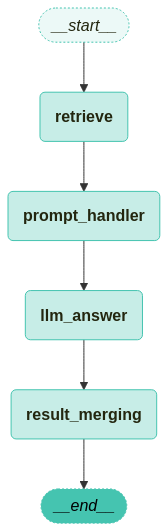

In [18]:
workflow = StateGraph(GraphState)

# 노드 추가
workflow.add_node("retrieve", retrieve)
workflow.add_node("prompt_handler", prompt_handler)
workflow.add_node("llm_answer", llm_answer)
workflow.add_node("result_merging", result_merging)

# 엣지 추가
workflow.add_edge("retrieve", "prompt_handler")
workflow.add_edge("prompt_handler", "llm_answer")
workflow.add_edge("llm_answer", "result_merging")
workflow.add_edge("result_merging", END)

# 시작점 설정
workflow.set_entry_point("retrieve")

# 메모리 설정
memory = MemorySaver()

app = workflow.compile(checkpointer=memory)

visualize_graph(app)